In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
from numpy import arange
from numpy.random import default_rng
from numpy.typing._extended_precision import float128
from scipy.optimize import minimize, Bounds, optimize
from scipy.optimize import brute
from skopt import gp_minimize
import skopt.plots as skplt

In [3]:
# Read in data and clean it

data2013 = pd.read_csv('2013_Events.csv')
data2012 = pd.read_csv('2012_Events.csv')
data2011 = pd.read_csv('2011_Events.csv')
data20092010 = pd.read_csv('2009_2010_Events.csv')

data2013 = data2013[['Event start date', 'Number of protesters', 'Location']]
data2012 = data2012[['Event start date', 'Number of protesters', 'Location']]
data2011 = data2011[['Event start date', 'Number of protesters', 'Location']]
data20092010 = data20092010[['Event date', '# protester', 'Location']]
data20092010.columns = ['Event start date', 'Number of protesters', 'Location']

# Combine multiple years into one dataframe
data = pd.concat([data2013, data2012, data2011, data20092010])

# Sort by event date (descending)
data['Event start date'] = pd.to_datetime(data['Event start date'])
data = data.sort_values(by = 'Event start date')

data_kyiv = data.loc[data['Location'] == 'Kyiv']

data['Number of events'] = 0
data['Number of protesters'] = pd.to_numeric(data['Number of protesters'], errors='coerce')

data_kyiv['Number of events'] = 0
data_kyiv['Number of protesters'] = pd.to_numeric(data_kyiv['Number of protesters'], errors='coerce')

# Combine entries that occur on the same date and sum the number of protesters
data = data.groupby(data['Event start date']).aggregate({'Number of events': 'size', 'Number of protesters': 'sum'})
data_kyiv = data_kyiv.groupby(data_kyiv['Event start date']).aggregate({'Number of events': 'size', 'Number of protesters': 'sum'})

/Users/lucaswebb/pandas/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [4]:
data.tail()

,Number of events,Number of protesters
Event start date,,
2013-12-27,20,405.0
2013-12-28,28,976.0
2013-12-29,42,7895.0
2013-12-30,26,543.0
2013-12-31,16,205.0


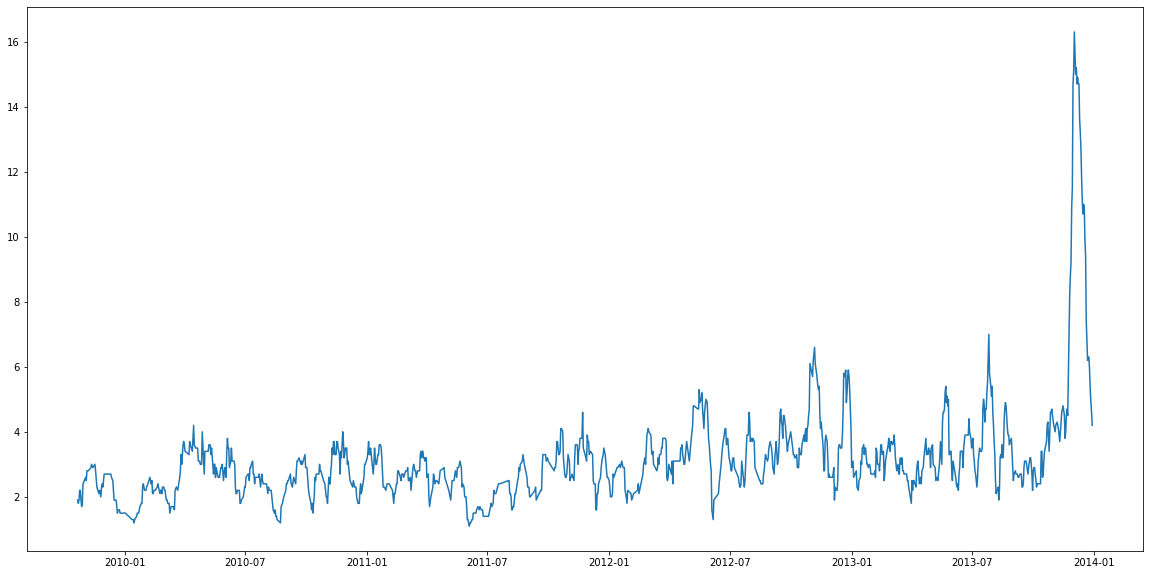

In [5]:
plt.figure(figsize=(20,10))
plt.plot(data_kyiv['Number of events'].rolling(10).mean(), label='data')

In [6]:
# Define function to calculate background activity level

def calculateN0(df, sigma, deltaT):
    return df['Number of events'].rolling(window=deltaT, win_type="gaussian", center=True).mean(std=sigma)
    # N0 is Null for the first and last deltaT/2 values

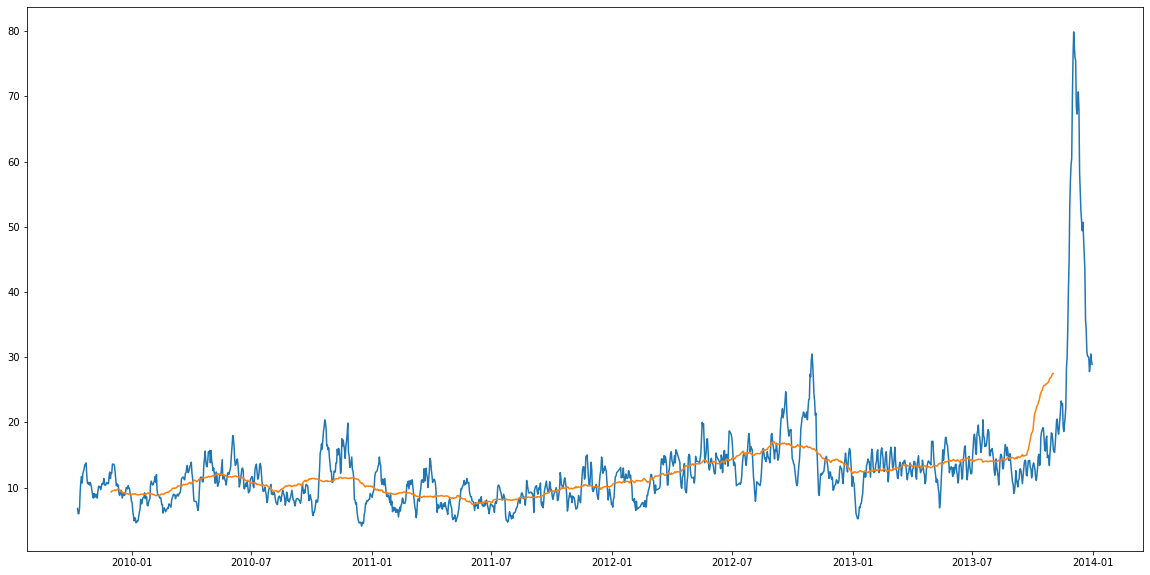

In [7]:
# Plot data and N0
plt.figure(figsize=(20,10))
plt.plot(data['Number of events'].rolling(10).mean(), label='data')
plt.plot(calculateN0(data, 360, 120), label='baseline')

In [8]:
print(MSE(data['Number of events'], calculateN0(data, 20, 10)))

NameError: name 'MSE' is not defined

In [9]:
# Define a function to create a new dataframe to be used in simulation

def createSimulationDF(df, sigma, deltaT):
    data1 = df.copy()
    data1['N0'] = calculateN0(data1, sigma, deltaT)
    data1['simulated'] = 0
    data1.reset_index(inplace=True)
    data1['Event start date'] = pd.to_numeric(pd.to_datetime(data1['Event start date']))
    data1 = data1[int(deltaT/2):int(-deltaT/2-1)]
    data1['simulated'][int(deltaT/2)] = 1
    return data1

In [10]:
# Define helper function to create simulated data

def simulaterHelper(x, args):
    arr = x[-1]
    d = (-x[:-1,0]/86400 + arr[0]/86400)/1000000000
    psum = x[:-1,1] * (np.exp((-(d-1))/args[0][1]) - np.exp(-d/args[0][1]))
    # arr[4] = np.random.poisson(arr[3] + args[0][0]*psum.sum(), 1)[0]
    # if arr[4] == 0:
    #     arr[4] = 1
    arr[4] = arr[3] + args[0][0]*psum.sum()
    # arr[4] = psum.sum()
    # arr[4] = d.sum()
    return arr

In [11]:
# Define function to create simulated data given simulationDF (to be used when fitting Nsec and Texcite)

def simulate(df, Nsec, Texcite):
    simulated_data = df.expanding(method="table").apply(simulaterHelper, Nsec, Texcite, raw=True, engine="numba")
    # simulated_data['Event start date'] = pd.to_datetime(simulated_data['Event start date'])
    return simulated_data

In [13]:
simulationDF = createSimulationDF(data, 360, 120)

In [15]:
simulated = simulate(simulationDF, 0.1, 0.1)

In [16]:
simulated.head()

,Event start date,Number of events,Number of protesters,N0,simulated
60,1.259539e+18,15.0,197.0,9.328223,9.328223
61,1.259626e+18,10.0,317.0,9.451891,10.951823
62,1.259712e+18,20.0,946.0,9.509561,10.509584
63,1.259798e+18,11.0,1388.0,9.517681,11.517636
64,1.259885e+18,7.0,383.0,9.567047,10.667088


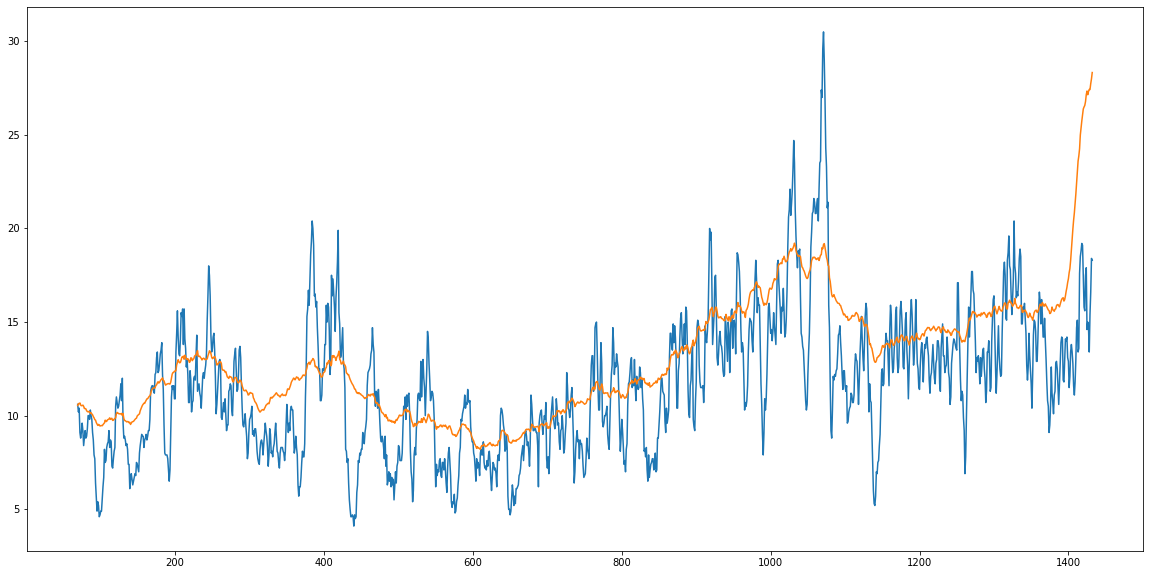

In [247]:
plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')

In [17]:
# Loss and error functions
def computeLoss(model, actual):
    return (model - (actual * np.log(model))).sum()

def MSE(model, actual):
    return np.power((actual - model).sum(), 2).sum() / len(actual)

In [366]:
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(MSE(simulated['simulated'], simulated['Number of events']))


-535.6306373370254
830.1176470588235


In [18]:
def functionToMinimize(x):
    sim = simulate(simulationDF, x[0], x[1])
    return computeLoss(sim['simulated'].astype(np.longdouble), sim['Number of events'].astype(np.longdouble))

In [248]:
x0 = [0.174, 9.9]
# res = minimize(functionToMinimize, x0, method = 'Nelder-Mead', options={'maxiter': 10})
res = brute(functionToMinimize, (slice(0.01, 0.9, 0.01), slice(0.1, 10, 1)), finish=None)#, full_output=True)
# , options={'maxiter': 1000}
# res = minimize(functionToMinimize, x0)
print(res)

[0.04 0.1 ]


In [249]:
# Compare baseline with baseline + contagion

print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))

-23520.61289378412
-23538.84793864135


In [19]:
# Lets try fitting a 3 parameter model with a constant baseline background

pd.options.mode.chained_assignment = None  # default='warn'
def createSimulationDF2(df, n):
    data1 = df.copy()
    data1['N0'] = n
    data1['simulated'] = 0
    data1.reset_index(inplace=True)
    data1['Event start date'] = pd.to_numeric(pd.to_datetime(data1['Event start date']))
    data1['simulated'][0] = 1
    return data1

def functionToMinimize2(x):
    sim = simulate(createSimulationDF2(data, x[2]), x[0], x[1])
    return computeLoss(sim['simulated'].astype(np.longdouble), sim['Number of events'].astype(np.longdouble))

In [18]:
x0 = [0.174, 9.9, 10]
res = minimize(functionToMinimize2, x0, method = 'Nelder-Mead', options={'maxiter': 10})
# , options={'maxiter': 1000}
# res = minimize(functionToMinimize, x0)
print(res)

 final_simplex: (array([[ 0.17077778, 10.32166667,  9.61111111],
       [ 0.17015496, 10.29259645,  9.62795782],
       [ 0.17109329, 10.29378472,  9.59606481],
       [ 0.17121971, 10.28875579,  9.63059414]]), array([-29453.91569035, -29265.09756773, -29208.95778794, -29148.64171827]))
           fun: -29453.915690348087
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 29
           nit: 10
        status: 2
       success: False
             x: array([ 0.17077778, 10.32166667,  9.61111111])


In [21]:
# Lets just look at Euromaiden (started November 21st 2013)

data_2013 = data.loc['2013-11-16':]

In [22]:
# Find average number of events per day up until Euromaiden
data.loc[:'2013-11-01']['Number of events'].mean()
# 11.56694560669456

11.56694560669456

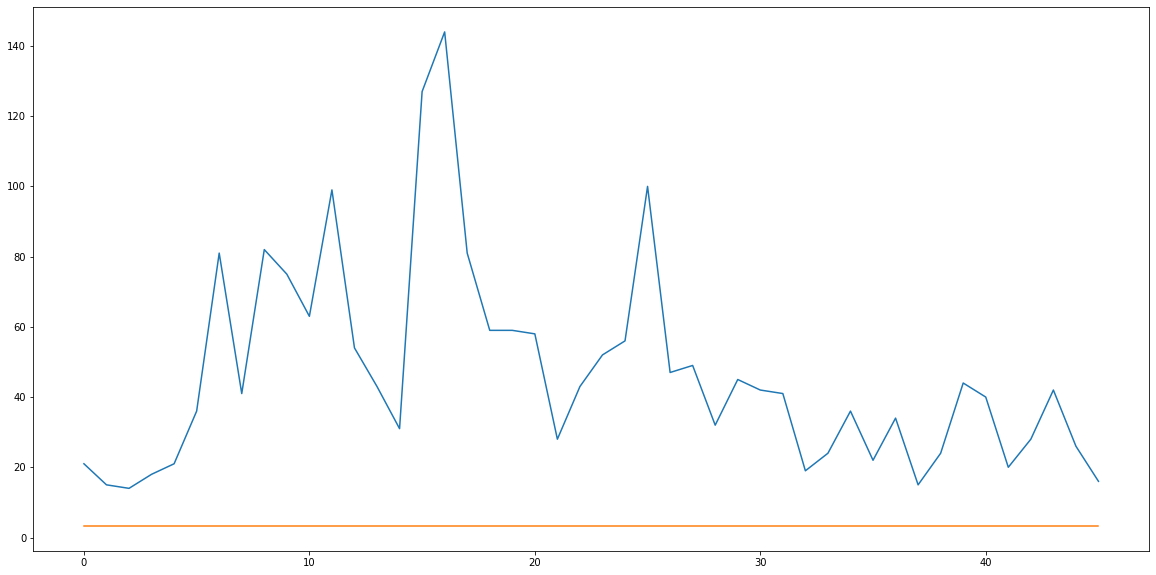

In [23]:
# Look at constant background model
data_2013N0 = createSimulationDF2(data_2013, 3.25)

# Plot data and N0
plt.figure(figsize=(20,10))
plt.plot(data_2013N0['Number of events'], label='data')
plt.plot(data_2013N0['N0'], label='background')

In [24]:
data_2013N0.shape[0]

46

In [25]:
simulationDF = data_2013N0

In [29]:
%%timeit
sim = simulate(simulationDF, 0.63, 1.76)

489 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [414]:
simulationDF = data_2013N0
x0 = [0.76, 1.1]
# res = minimize(functionToMinimize, x0, method = 'Nelder-Mead', options={'maxiter': 10})
res = brute(functionToMinimize, (slice(0.01, 0.9, 0.01), slice(0.1, 15, 1)), finish=minimize)
print(res)
# 0.71725041, 1.22031264 after 100000 iterations

[0.71605729 1.04059328]


/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-7108.936316801166
-6827.483056603426
-5351.051478681025


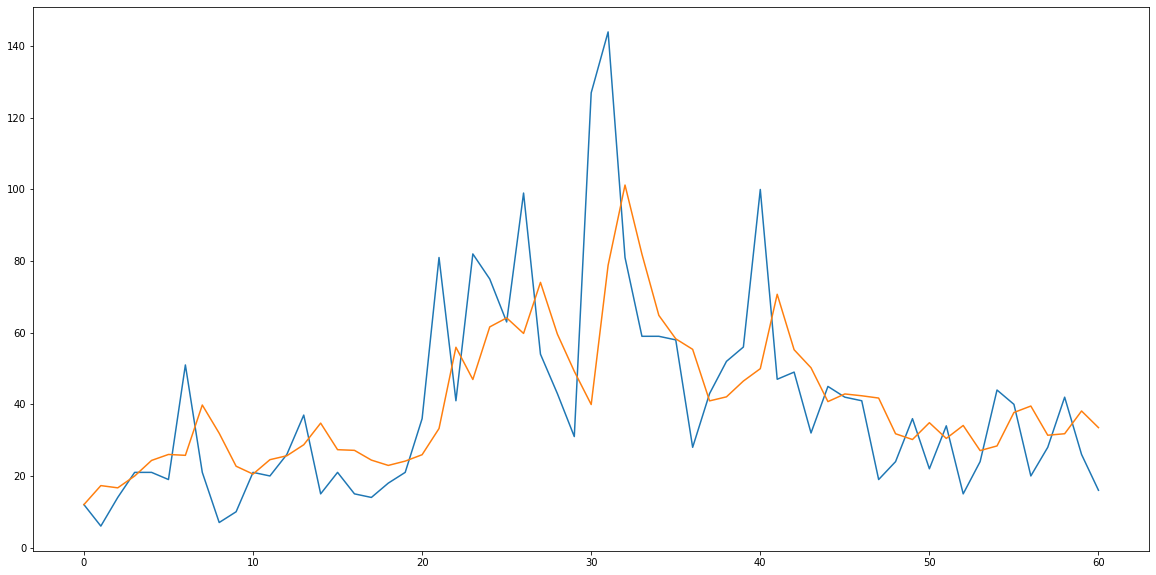

In [417]:
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'], label='data')
plt.plot(simulated['simulated'], label='model')

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))

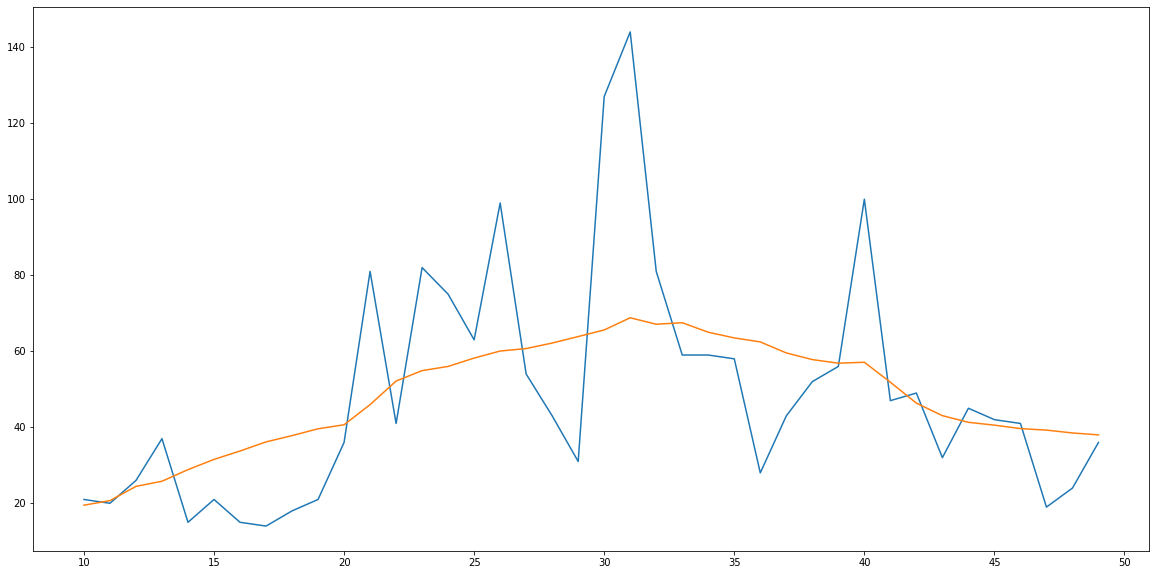

In [418]:
# Apply weighted average background model to Euromaiden

data_2013N0 = createSimulationDF(data_2013, 300, 20)

# Plot data and N0
plt.figure(figsize=(20,10))
plt.plot(data_2013N0['Number of events'], label='data')
plt.plot(data_2013N0['N0'], label='background')

In [419]:
data_2013N0.head()

,Event start date,Number of events,Number of protesters,N0,simulated
10,1384128000000000000,21,736.0,19.500489,1
11,1384214400000000000,20,483.0,20.700133,0
12,1384300800000000000,26,1992.0,24.448974,0
13,1384387200000000000,37,1066.0,25.798830,0
14,1384473600000000000,15,999.0,28.848206,0


In [420]:
simulationDF = data_2013N0
x0 = [0.76, 7]
# res = minimize(functionToMinimize, x0, method = 'Nelder-Mead', options={'maxiter': 20000})
res = brute(functionToMinimize, (slice(0.01, 0.9, 0.01), slice(0.1, 5, 0.1)), finish=None)#, full_output=True)
print(res)

[0.06 0.1 ]


-5807.824369450476
-5804.047330463885


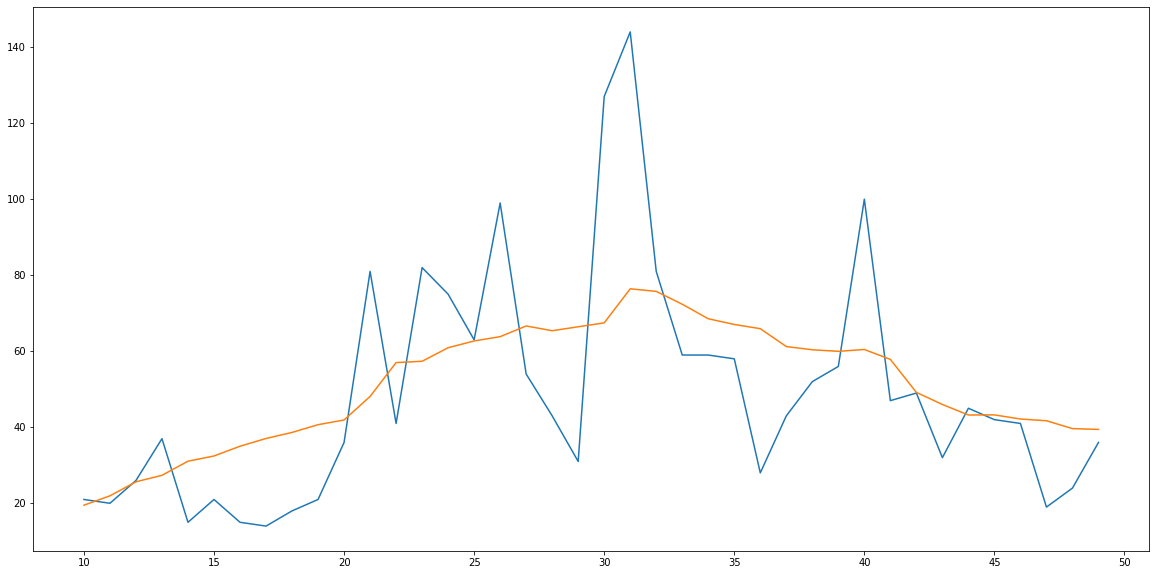

In [421]:
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'], label='data')
plt.plot(simulated['simulated'], label='model')

print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))

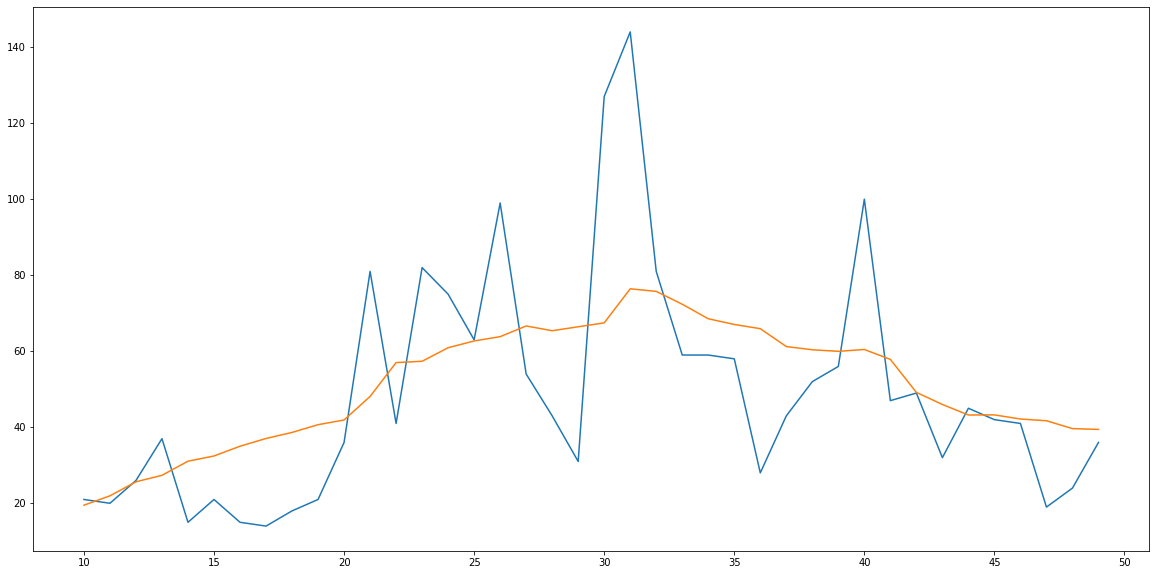

In [238]:
simulated2 = simulate(simulationDF, 0.06, 0.1)

plt.figure(figsize=(20,10))
plt.plot(simulated2['Number of events'], label='data')
plt.plot(simulated2['simulated'], label='model')

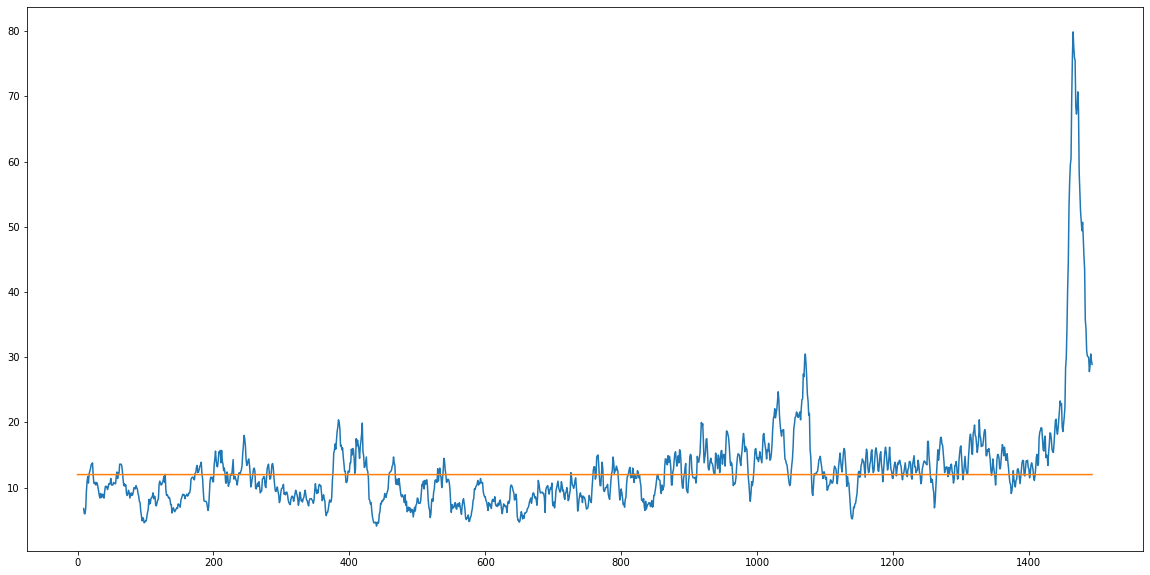

In [405]:
# Look at entire dataset with baseline
simulationDF = createSimulationDF2(data, 12)

plt.figure(figsize=(20,10))
plt.plot(simulationDF['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulationDF['N0'], label='baseline')

In [406]:
res = brute(functionToMinimize, (slice(0.01, 0.4, 0.01), slice(0.1, 10, 0.1)), finish=None)#, full_output=True)
print(res)

[0.21 0.1 ]


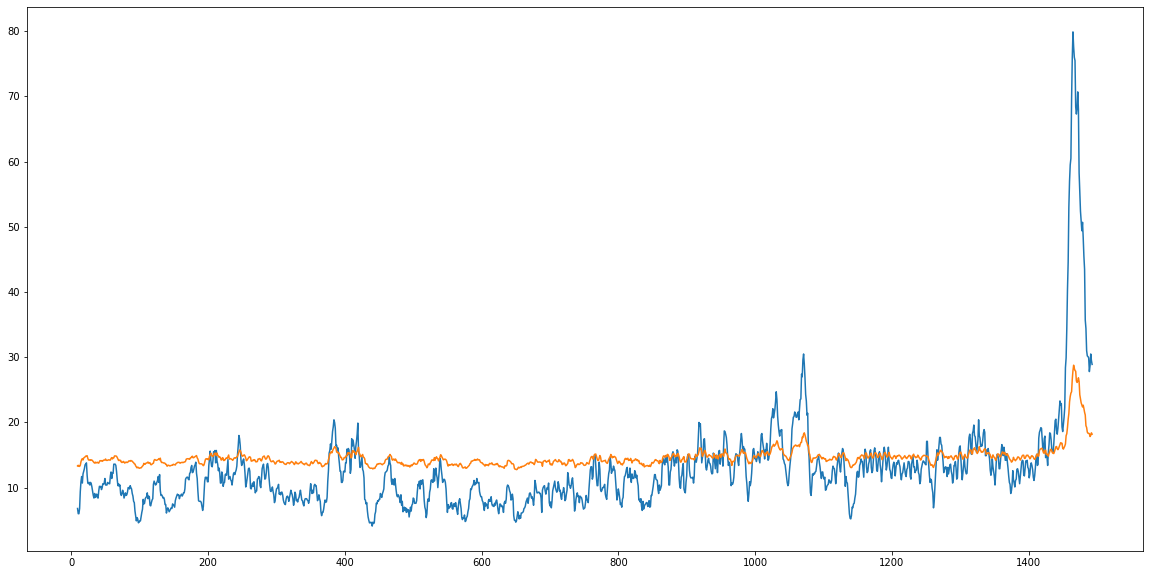

In [407]:
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')

In [408]:
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))

-30150.17149751778
-29342.37919891713


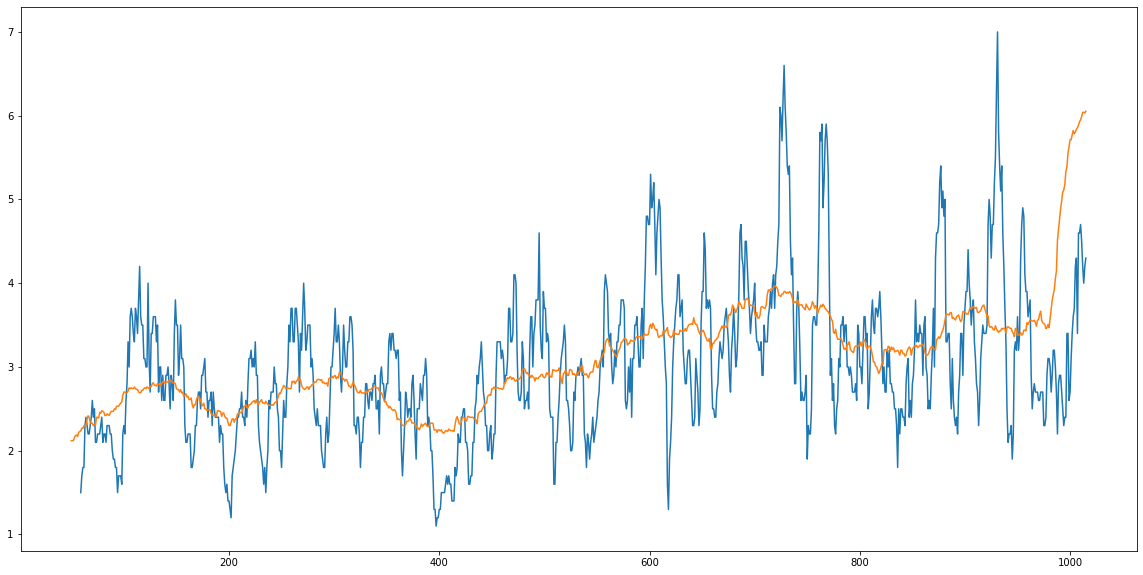

In [402]:
# Look just at Kyiv

kyiv_N0 = createSimulationDF(data_kyiv, 300, 100)

# Plot data and N0
plt.figure(figsize=(20,10))
plt.plot(kyiv_N0['Number of events'].rolling(10).mean(), label='data')
plt.plot(kyiv_N0['N0'], label='background')

In [403]:
simulationDF = kyiv_N0
res = brute(functionToMinimize, (slice(0.01, 0.9, 0.01), slice(0.1, 15, 1)), finish=None)#, full_output=True)
print(res)

[0.02 0.1 ]


-1100.814367524199
-350.0501148517097
-349.4876100082761


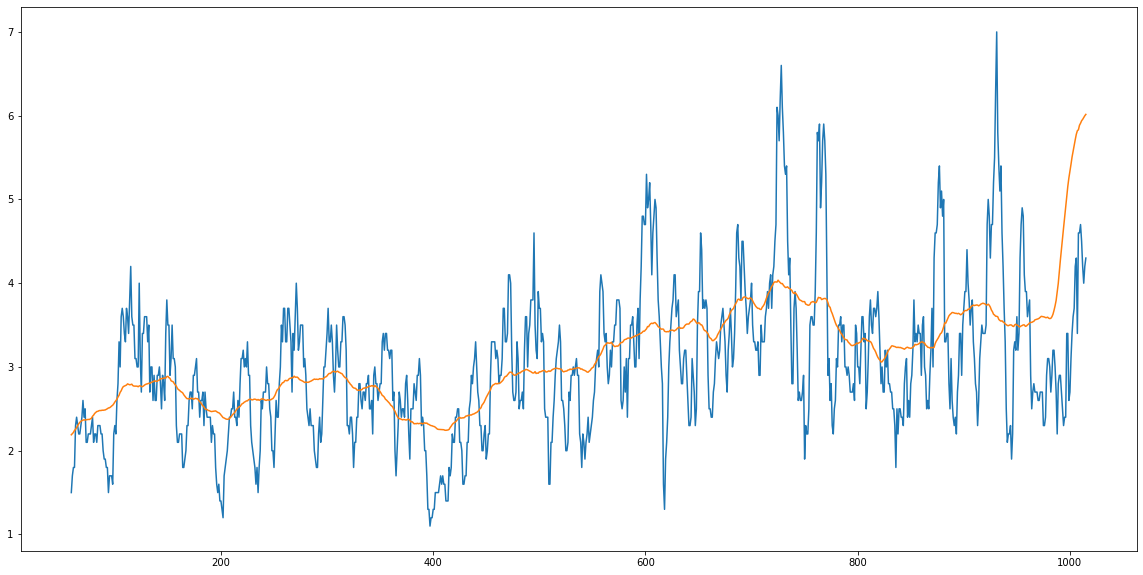

In [404]:
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot((simulated['simulated']).rolling(10).mean(), label='model')

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))


In [374]:
simulated.tail()

,Event start date,Number of events,Number of protesters,N0,simulated
1011,1.383178e+18,3.0,83.0,5.989558,2.0
1012,1.383350e+18,1.0,1.0,6.040030,4.0
1013,1.383523e+18,2.0,999.0,6.040948,8.0
1014,1.383610e+18,6.0,343.0,6.031929,7.0
1015,1.383782e+18,8.0,5648.0,6.052591,8.0


In [375]:
data_kyiv['Number of events'].mean()


3.253045923149016

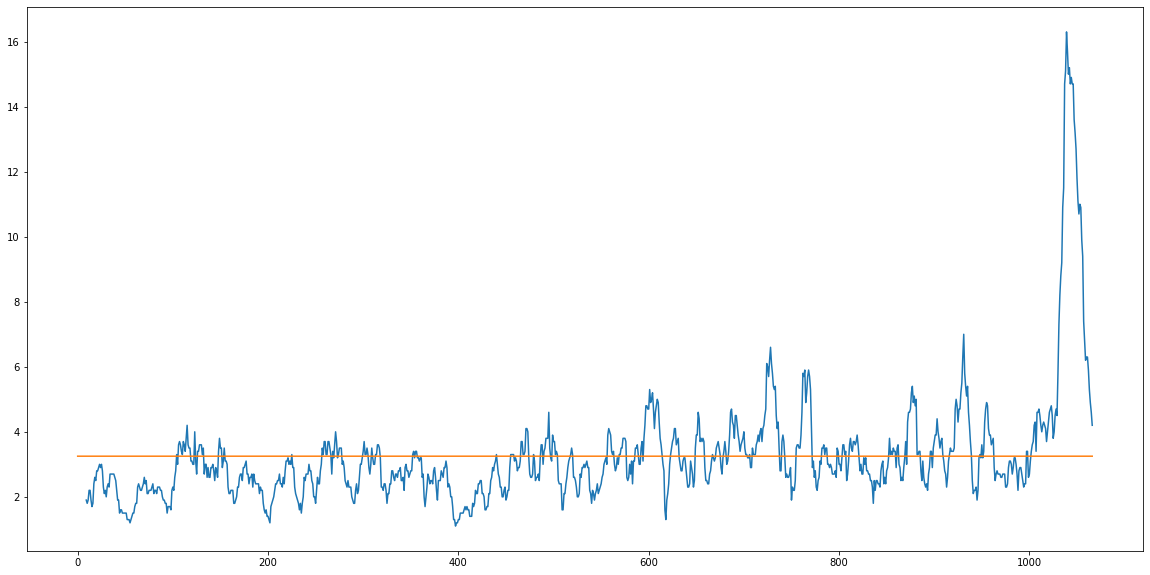

In [396]:
# Kyiv with constant background

kyiv_N0 = createSimulationDF2(data_kyiv, 3.25)

# Plot data and N0
plt.figure(figsize=(20,10))
plt.plot(kyiv_N0['Number of events'].rolling(10).mean(), label='data')
plt.plot(kyiv_N0['N0'], label='background')

In [397]:
simulationDF = kyiv_N0
res = brute(functionToMinimize, (slice(0.01, 0.5, 0.01), slice(0.1, 5, 0.1)), finish=None)#, full_output=True)
print(res)
#[0.19325032 2.09839541]

[0.19 2.1 ]


-1726.746849998198
-698.7570850221182
-623.361492301854


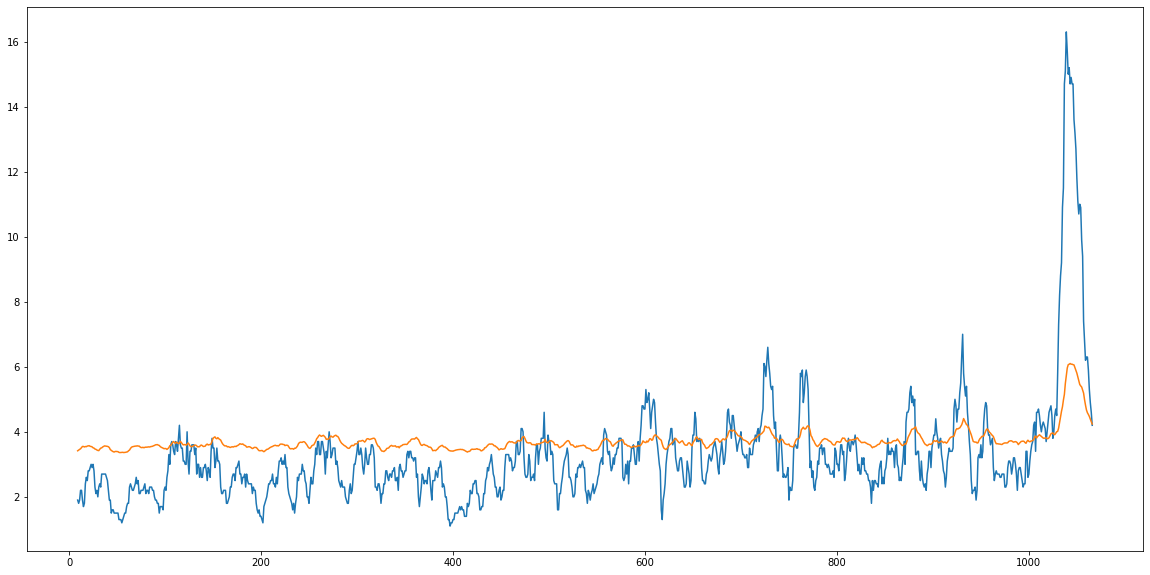

In [398]:
simulated = simulate(simulationDF, 0.19, 2.1)

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))

In [390]:
simulated.head()

,Event start date,Number of events,Number of protesters,N0,simulated
0,1.254355e+18,2.0,3.0,3.25,6.0
1,1.254874e+18,1.0,0.0,3.25,2.0
2,1.254960e+18,1.0,0.0,3.25,1.0
3,1.255133e+18,1.0,101.0,3.25,4.0
4,1.255478e+18,5.0,5502.0,3.25,4.0


In [399]:
# Test the predictive power of constant baseline in kyiv
# Train on the first half
kyiv_N0 = createSimulationDF2(data_kyiv.loc[:'2012-01-01'], data_kyiv.loc[:'2012-01-01']['Number of events'].mean())
simulationDF = kyiv_N0
res = brute(functionToMinimize, (slice(0.01, 0.5, 0.01), slice(0.1, 5, 0.1)), finish=None)#, full_output=True)
print(res)

[0.04 0.1 ]


76.14782510061205
77.12551762346311


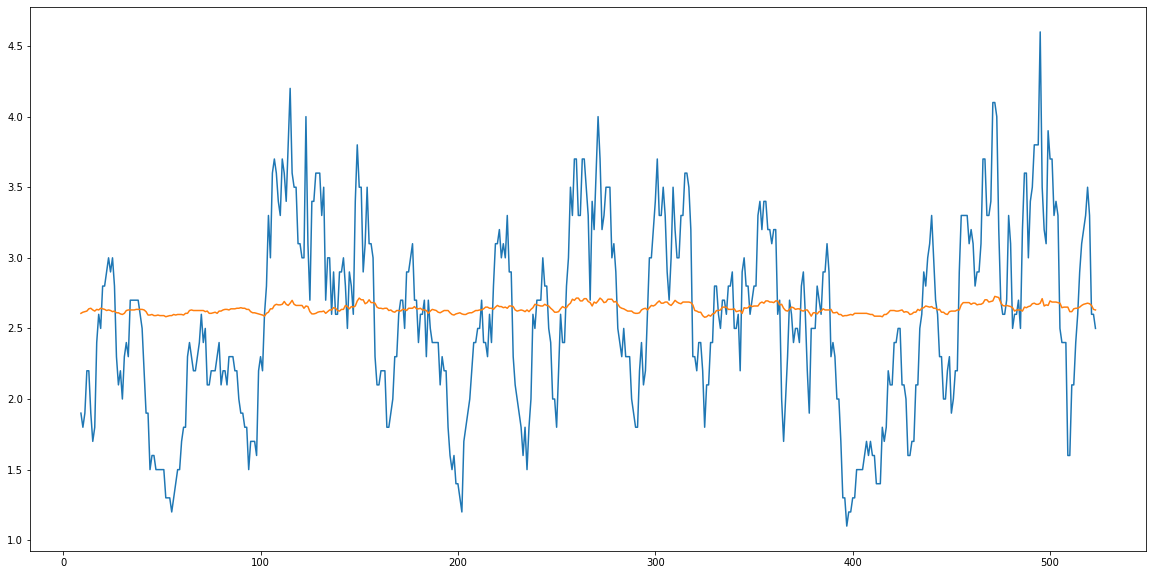

In [400]:
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')

print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))

-799.7884652888702
-777.2966652352349


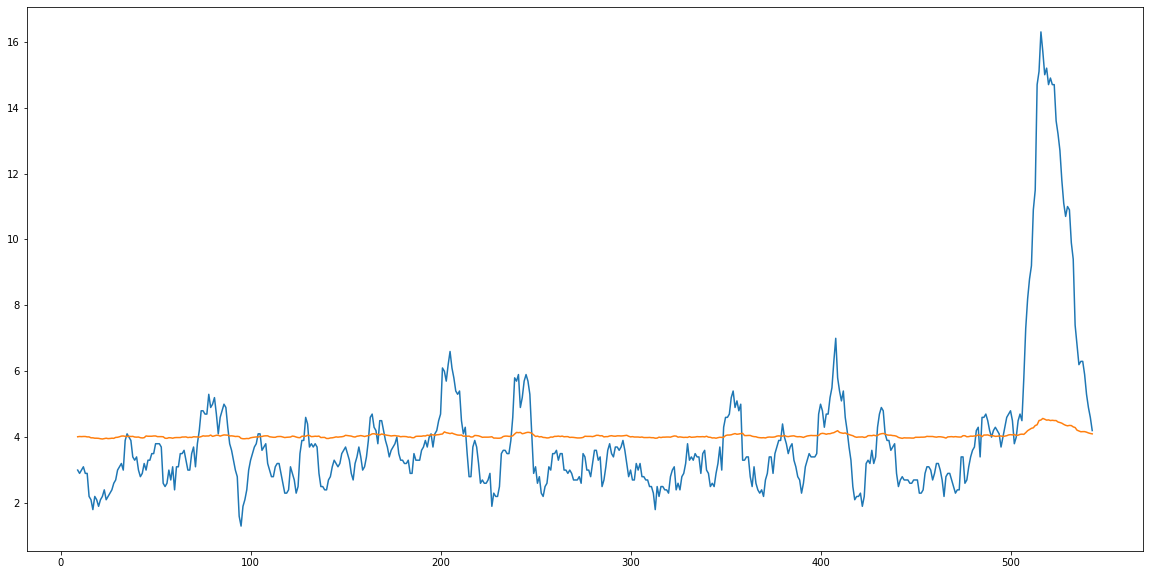

In [401]:
# Test on the second half
kyiv_N0 = createSimulationDF2(data_kyiv.loc['2012-01-01':], data_kyiv.loc['2012-01-01':]['Number of events'].mean())
simulationDF = kyiv_N0
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')

print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))

In [147]:
# Look at just euromaiden with constant background to compare with distance model and verify models produce same output

toCompare = data_kyiv.loc['2013-11-16':]

index = pd.date_range('2013-11-16','2013-12-31')
toCompare = toCompare.reindex(index, fill_value=0.0)
toCompare = toCompare.reset_index()
del toCompare['index']

def l2Error(simulated, actual):
    return np.power(actual - simulated, 2).sum()

def functionToMinimize3(params):
    sim = simulate(simulationDF, params[0], params[1])
    return l2Error(sim['simulated'], toCompare['Number of events'])

In [148]:
data_2013N0 = createSimulationDF2(data_2013, 3.25)
simulationDF = data_2013N0

In [151]:
functionToMinimize3([0.1, 1])

2062.119759227934

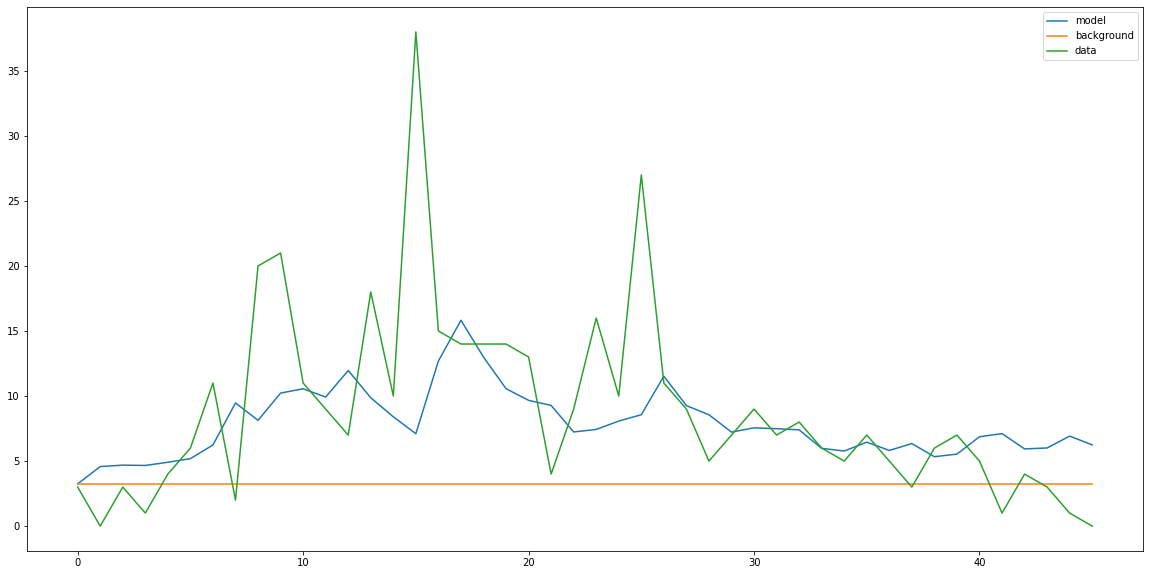

In [152]:
sim = simulate(simulationDF, 0.1, 1)
plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='model')
plt.plot(sim['N0'], label='background')
plt.plot(toCompare['Number of events'], label='data')
plt.legend()

In [153]:
sim.head()


,Event start date,Number of events,Number of protesters,N0,simulated
0,1.384560e+18,21.0,386.0,3.25,3.250000
1,1.384646e+18,15.0,1339.0,3.25,4.577453
2,1.384733e+18,14.0,1030.0,3.25,4.686524
3,1.384819e+18,18.0,267.0,3.25,4.663436
4,1.384906e+18,21.0,351.0,3.25,4.907791


In [168]:
%%time
res = gp_minimize(functionToMinimize3, [(0.0, 1.0), (0.0001, 20.0)], n_calls=25, noise=1e-10, n_initial_points=1, random_state=123)

CPU times: user 48.1 s, sys: 10.5 s, total: 58.6 s
Wall time: 33 s


In [160]:
res.x

[0.1305589504548287, 2.3388327564709708]

In [161]:
res.fun

1878.4805871370515

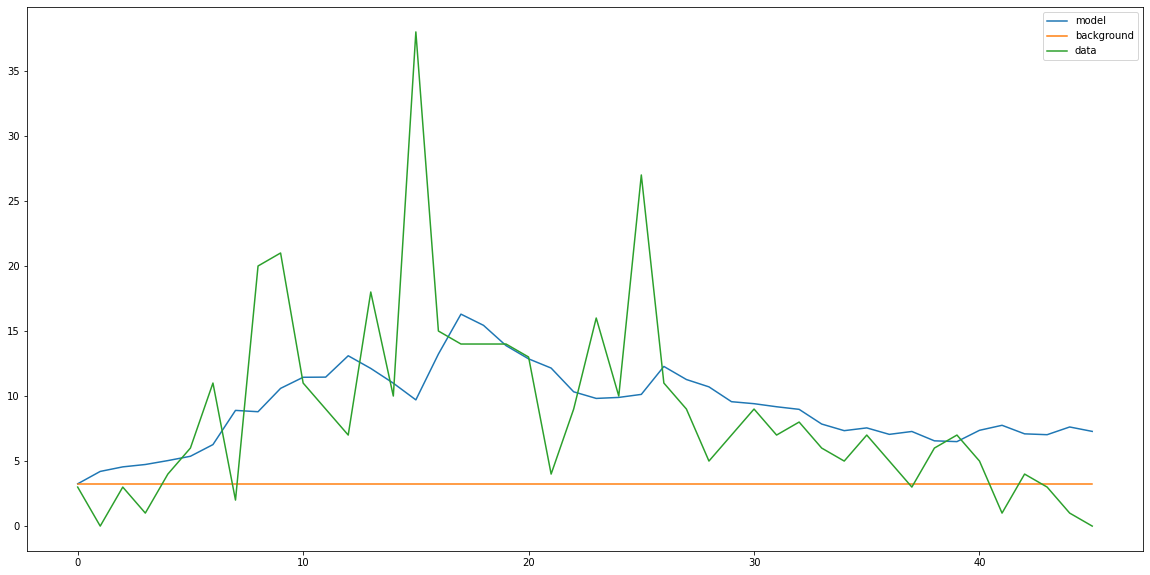

In [162]:
sim = simulate(simulationDF, res.x[0], res.x[1])
plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='model')
plt.plot(sim['N0'], label='background')
plt.plot(toCompare['Number of events'], label='data')
plt.legend()

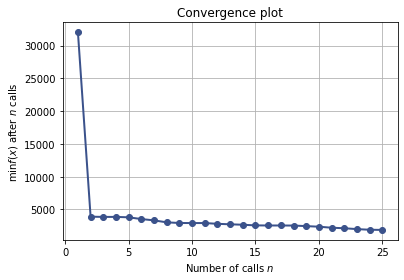

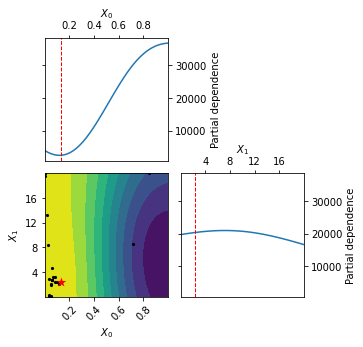

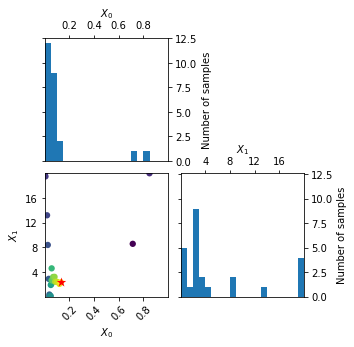

In [163]:
skplt.plot_convergence(res);
skplt.plot_objective(res);
skplt.plot_evaluations(res);